### 0. Dependencies

In [ ]:
from glob import glob
import numpy as np
import pandas as pd
import tomotopy as tp
import networkx as nx
import spacy
from utils import *
from sklearn.metrics import silhouette_score
from nltk.sentiment import SentimentIntensityAnalyzer
from spacy.lang.en.stop_words import STOP_WORDS

from seaborn import heatmap
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from numpy.linalg import norm
import matplotlib.pyplot as plt

np.random.seed(0)
# SPECIFY THE LANGUAGE
SPACY_LANG = 'en_core_web_sm'

# disable some of the modules we do not use to increase the processing speed
sp = spacy.load(SPACY_LANG, disable=["ner",  "entity_linker", "parser", "entity",
                                     "textcat", "textcat_multilabel",  "senter",  "sentencizer",  "transformer"
                                    ])

### 1. Functions

In [2]:
def ts_log(a,b):
    """Logarithmic similarity between two vectors (used for topic similarity)"""
    overlap = np.logical_and((a != 0), (b != 0))
    a[~overlap] *= 0
    b[~overlap] *=0
    ids = np.argwhere(overlap).flatten()
    return (np.abs(np.log(a[ids]) - np.log(b[ids]))).sum()

def cossim(a,b):
    """Cosine similarity between two vectors
    Arguments:
        a: np.array, first vector
        b: np.array, second vector
    Output:
        cosine similarity between two vectors"""
    return np.dot(a,b)/(norm(a)*norm(b))

def ts_cos(a: int, b: int, semantic_matrix, topn = 10 ):
    """Cosine similarity between two vectors (used for topic similarity)
        Arguments:
            a: int, index of the first topic
            b: int, index of the second topic
            semantic_matrix: np.array, matrix of semantic vectors
            topn: int, number of top words to use for topic similarity
        Output:
            median cosine similarity between two topics
    """
    a_top = (semantic_matrix[a]).argsort()[-topn:]
    b_top = (semantic_matrix[b]).argsort()[-topn:]
    av = np.zeros((topn,semantic_matrix.shape[0]))
    bv = np.zeros((topn,semantic_matrix.shape[0]))
    for i, w in enumerate(a_top):
        av[i] = semantic_matrix[:,w]
    for i, w in enumerate(b_top):
        bv[i] = semantic_matrix[:,w]

    distances = 1 - np.clip(np.matmul(av, bv.T)/((norm(av, axis=1) * norm(bv, axis = 1)[:,None]).T),\
                            a_min=0., a_max=1.)
    return np.median(distances)

def filter_vocab(vocab):
    """Filter the vocabulary to remove stop words and punctuation"""
    NUM_DOCS = len(vocab)
    vocab_lemma = preprocess_parallel(vocab, sp= sp, num_docs= NUM_DOCS, chunksize=10000)
    processed = set()
    feature_dict = dict()
    for i, v in enumerate(vocab_lemma):
        feature_dict[i] = v
        if len(v) > 1:
            for vv in v:
                processed.update(vv)
        else:
            processed.update(v)
    return processed, feature_dict

def find_t(Z, adj, max_t = 2, num_steps=25, t_vals = None):
    """Find the optimal t for the hierarchical clustering"""
    score = list()
    if t_vals is None:
        t_vals = np.linspace(0.1, max_t, num_steps)
    for t in t_vals:
        clst = fcluster(Z, t=t)
        try:
            score.append(silhouette_score(adj, clst, metric="precomputed", random_state=0))
        except:
            score.append(0)
    return t_vals[np.argmax(score)]

def get_global_topic_representation(in_members, topic_matrix, cluster_name2id):
    """Get the global topic representation for a cluster of topics
    Arguments:
        in_members: list, list of topic names/ids
        topic_matrix: np.array, matrix of topic vectors
        cluster_name2id: dict, mapping from topic names to ids
    Output:
        np.array, matrix of global topic representation"""
    m = topic_matrix[[cluster_name2id[member] for member in in_members]]
    return m.mean(0)

### 2. Load and preprocess docs

In [3]:
### Specify the names and periods of the corpora
context = "environment" 
newspapers = ["The New York Times", "Chicago",  "The Times", "Irish Times", "La Stampa", "El Pais", "nzz", "Le Figaro",]
periods = ['1999-2003', '2004-2008', '2009-2013', '2014-2018']

In [ ]:
### Extract Vocabulary from the corpora of foreign newspapers (used further to translate the vocabularies)
for pname in newspapers:
    paths = glob("data/%s/%s*.obj" %(context,pname))
    for path in paths:
        pperiod = path.split("_")[1].split(".")[0]
        model = tp.PAModel.load(path)
        if pname in ["La Stampa", "El Pais", "nzz", "Le Figaro"]:
            _vocab = pd.DataFrame(list(model.vocabs))
            writer = pd.ExcelWriter("translations/%s/%s_%s_vocab.xlsx" %(context,pname, pperiod), engine='xlsxwriter')
            _vocab.to_excel(writer, sheet_name='0', index=False)
            writer.save()

In [5]:
data = dict()
vocab = set()
model_idx2token = dict()

## Go throught each period-newspaper pair and extract the vocabulary
## in case it is a foreign newspaper, translate the vocabulary
## assemble the data into a dictionary, create a unified vocabulary
for pname in newspapers:
    paths = glob("data/%s/%s*.obj" %(context,pname))
    data[pname] = dict()
    model_idx2token[pname] = dict()
    for path in paths:
        pperiod = path.split("_")[1].split(".")[0]
        model = tp.PAModel.load(path)
        if pname in ["La Stampa", "El Pais", "nzz", "Le Figaro"]:
            raw_vocabs = pd.read_excel("translations/%s/%s_%s_trs.xlsx" %(context,pname, pperiod))[0].values.tolist()
        else:
            raw_vocabs = list(model.vocabs)
        raw_vocabs = [str(t) for t in raw_vocabs]
        _vocab, idx2token = filter_vocab(raw_vocabs)
        model_idx2token[pname][pperiod] = idx2token
        data[pname][pperiod] = model
        vocab.update(_vocab)
    print("Finished: %s" %(pname))

Finished: The New York Times
Finished: Chicago
Finished: The Times
Finished: Irish Times
Finished: La Stampa
Finished: El Pais
Finished: nzz
Finished: Le Figaro


#### Vocabulary Setup

In [6]:
### a little bit of a bookkeeping
num_topics = 0
token2index = dict()
index2token = dict()
for pname in data.values():
    for pperiod in pname.values():
        num_topics += pperiod.k2
print("Total number of topics: %s" %num_topics)

## dictionary that maps tokens names to ids (and vice versa)
for i, key in enumerate(vocab):
    token2index[key] = i
    index2token[i] = key
topic_matrix = np.zeros((num_topics, len(vocab))) # matrix that woudl contain every representation of topics
print("Vocab size: %s" %len(vocab))


Total number of topics: 194
Vocab size: 313525


### 3. Topic Modelling/Analysis

Now that we have loaded, assembled and preprocessed all the information we can move to the analysis part

#### 3.1. Semantic Matrix

In [7]:
### Here we crete the topic (or SEMANTIC Matrix) matrix
### Each row is a representation of each single topic
global_id = 0
out_of_dict = 0 
cluster_name = []
cluster_name2id = dict()
ttop_words = [] # top 10 topic words (per each topic)
## Go through each period-newspaper pair and extract the topic representation
for pname, pdata in data.items():
    for pperiod, item in pdata.items():
        used_vocab = model_idx2token[pname][pperiod].values()
        for k in range(item.k2):
            cluster_name.append("%s %s (%s)" %(pname, pperiod, k))
            cluster_name2id[cluster_name[-1]] = global_id
            temp_vocab = dict()
            top_words = set([tword[0] for tword in item.get_topic_words(k)])
            ttop_words.append(top_words)
            for v, w in zip(used_vocab, item.get_topic_word_dist(k)):
                if len(v) == 0:
                    continue
                elif len(v) == 1:
                    word_id = token2index[v[0]]
                    topic_matrix[global_id, word_id] += w
                else:
                    count_v = float(len(v))
                    for vv in v:
                        try:
                            word_id = token2index[vv]
                            topic_matrix[global_id, word_id] += w/count_v
                        except:
                            try:
                                _v = "".join(v)
                                word_id = token2index[_v]
                                topic_matrix[global_id, word_id] += w/count_v
                            except:
                                #print(_v, v)
                                out_of_dict +=1

            global_id += 1
np.save("topic_matrix.npy", topic_matrix)


### PEDIOD IDS
### Bookkeeping for the periods (so that it is easier to find topics using ids or names)
periods = ['1999-2003', '2004-2008', '2009-2013', '2014-2018']
period_ids = dict()
for p in periods:
    ids = list()
    for i, cname in enumerate(cluster_name):
        if p in cname: 
            ids.append(i)
    period_ids[p] = ids

#### 3.2 Adjacency/Distance Matrix 
Matrix contains distances between each pair of existing topics

In [26]:
TOPN = 20

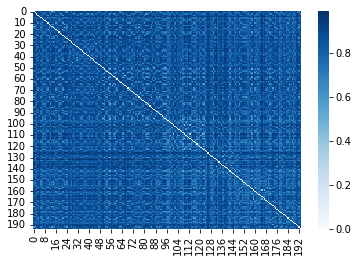

In [27]:
adj = np.zeros((num_topics, num_topics))
for i in range(num_topics):
    for j in range(i, num_topics):
        if i == j:
            continue
        adj[i,j] = ts_cos(i,j, topic_matrix, topn=TOPN) ## distance between topics
adj += adj.T
heatmap(adj, cmap="Blues")
plt.show()

#### 3.3 Condensed Adjacency Matrix
Here we go from inner topics and form global topics (aka representation of clusters of topics)

Number of clusters in 1999-2003 is 13 (1.88) with = 1.04
Number of clusters in 2004-2008 is 10 (1.85) with = 1.13
Number of clusters in 2009-2013 is 6 (2.03) with = 1.04
Number of clusters in 2014-2018 is 7 (1.79) with = 1.13
Condensed Matrix is calculated


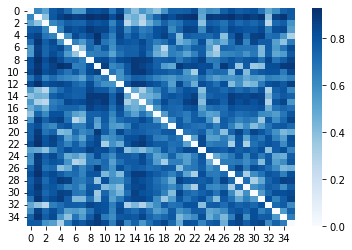

Number of clusters is  36


In [35]:
condensed_clusters = dict()
condensed_clusters_by_id = dict()
curr_id = 0
for prd in periods:
    prd_cns = np.array([cn for cn in cluster_name if prd in cn])
    prd_ids = np.array([cluster_name2id[cn] for cn in prd_cns])
    prd_adj = adj[prd_ids[:,None], prd_ids]
    prd_Z = linkage(squareform(prd_adj), 'ward')
    prd_t = find_t(prd_Z, prd_adj, max_t=1.5, num_steps=50)

    prd_cls = fcluster(prd_Z, t=prd_t)
    print("Number of clusters in %s is %s (%.2f) with = %.2f" %(prd, max(prd_cls), np.max(prd_Z.T[2]), prd_t))
    condensed_clusters[prd] = dict()
    for curr_cls in range(1, max(prd_cls)+1):
        in_members = []
        in_words = []
        for lc_name, lc_id, cluster in zip(prd_cns, prd_ids, prd_cls):
            if cluster == curr_cls:
                in_members.append(lc_name)
                in_words.extend(ttop_words[lc_id])
        
        condensed_clusters[prd][curr_id] = {"members": in_members,
                                            "period": prd,
                                            "words": in_words,
                                            "representation": get_global_topic_representation(in_members, topic_matrix, cluster_name2id)}
        
        condensed_clusters_by_id[curr_id] = condensed_clusters[prd][curr_id]
        curr_id += 1

condensed_matrix = np.zeros((curr_id, topic_matrix.shape[1]))
condensed_adj = np.zeros((curr_id, curr_id))
for period,v in condensed_clusters.items():
    for k, vv in v.items():
        condensed_matrix[k] = vv["representation"]
print("Condensed Matrix is calculated")
for i in range(curr_id):
    for j in range(i, curr_id):
        if i == j:
            continue
        condensed_adj[i,j] = ts_cos(i,j, condensed_matrix, topn=TOPN) #15 is the best
condensed_adj += condensed_adj.T
heatmap(condensed_adj, cmap="Blues")
plt.show()
print("Number of clusters is ", curr_id)

### 4. Topic Evolution and Sentiment Analysis
Now that we have representation of the GLOBAL topics (as well as the Adjacency Matrix with disctances between these topics), we can build a *temporal graph*.

In [41]:
### Here we build two graphs:
### 1. Graph G, where we remove links based on the 10th quantile of the distances
### Build full graph
G = nx.Graph()
period_c = ["red", "blue", "green", "pink"]
for i in range(len(periods)-1):
    curr_prd = periods[i]
    next_prd = periods[i+1]
    
    for curr_cls in condensed_clusters[curr_prd].keys():
        for next_cls in condensed_clusters[next_prd].keys():
            G.add_edge(curr_cls, next_cls, distance=condensed_adj[curr_cls, next_cls])
            G.nodes[curr_cls]["period"] = period_c[i]
            G.nodes[next_cls]["period"] = period_c[i+1]
l_thr = np.quantile([v["distance"] for _, _ ,v in G.edges(data = True)], 0.10)
to_remove = list()

### We save the edges that we should remove 
for i, j, v in G.edges(data=True):
    if v["distance"]>l_thr:
        to_remove.append((i,j))
## here we remove the edges (this is done in a separate loop to avoid changing the graph while iterating over it, specifics of NetworkX)
for i in to_remove:
    G.remove_edge(i[0], i[1])
### 2. Graph D, where we remove links based on the 15th quantile of the distances
### Build full graph
D = nx.Graph()
period_c = ["red", "blue", "green", "pink"]
for i in range(len(periods)-1):
    curr_prd = periods[i]
    next_prd = periods[i+1]
    
    for curr_cls in condensed_clusters[curr_prd].keys():
        for next_cls in condensed_clusters[next_prd].keys():
            D.add_edge(curr_cls, next_cls, distance=condensed_adj[curr_cls, next_cls])
            D.nodes[curr_cls]["period"] = period_c[i]
            D.nodes[next_cls]["period"] = period_c[i+1]
l_thr = np.quantile([v["distance"] for _, _ ,v in D.edges(data = True)], 0.15)
to_remove = list()
for i, j, v in D.edges(data=True):
    if v["distance"]>l_thr:
        to_remove.append((i,j))

for i in to_remove:
    D.remove_edge(i[0], i[1])

In [42]:
### Save results
result_csv = []
for cid in range(condensed_adj.shape[0]):
    words = condensed_matrix[cid].argsort()[-10:]
    result_csv.append({"id": cid, 
                   "members": condensed_clusters_by_id[cid]["members"],
                   "edges": G.edges(cid),
                   "words": [index2token[i] for i in words]})

result_csv = pd.DataFrame(result_csv)
result_csv.to_csv("topics/%s.csv"%context)

#### 4.1 Sentiment Analysis and Results

In [ ]:
sia = SentimentIntensityAnalyzer()

In [125]:
C_ID = 2

#print("Number of Members is ", len(condensed_clusters_by_id[C_ID]["members"]))
print(condensed_clusters_by_id[C_ID]["members"])
print("")
words = sorted(condensed_matrix[C_ID].argsort()[-10:])
print(", ".join([index2token[i] for i in words]))
print("")
############### Sentiment
sia_words = condensed_matrix[C_ID].argsort()[-50:]
sia_words = " ".join([index2token[i] for i in sia_words])
polarity_score = sia.polarity_scores(sia_words)["compound"]
bins = [-1.        , -0.71428571, -0.42857143, -0.14285714,  0.14285714,
        0.42857143,  0.71428571,  1.        ]
polarity_cat = np.digitize(polarity_score, bins)
print("SENTIMENT SCORE: %.2f (%s)" %(polarity_score, polarity_cat))
### Some topics are unstable, aka noisy. Here we remove them based on the threshold                  
print("Satisfies thr:", np.sum(condensed_matrix[C_ID][condensed_matrix[C_ID].argsort()[-20:]]) > 0.05)
print("Satisfies thr:", np.sum(condensed_matrix[C_ID][condensed_matrix[C_ID].argsort()[-10:]]) > 0.03)
### Print out edges from the two graphs
print("10th-Edges", G.edges(C_ID))
print("15th-Edges", D.edges(C_ID))

['The Times 1999-2003 (2)', 'Irish Times 1999-2003 (1)', 'La Stampa 1999-2003 (5)', 'El Pais 1999-2003 (1)', 'nzz 1999-2003 (2)']

leave, world, think, time, know, look, life, people, man, want

SENTIMENT SCORE: 0.96 (7)
Satisfies thr: False
Satisfies thr: False
10th-Edges [(2, 13), (2, 14), (2, 15)]
15th-Edges [(2, 13), (2, 14), (2, 15), (2, 16)]


In [25]:
### Print top words for every global topic
for cid in range(condensed_adj.shape[0]):
    words = condensed_matrix[cid].argsort()[-6:]
    print(cid, ", ".join([index2token[i] for i in words]), G.degree(cid))

0 time, music, think, know, leave, book 1
1 child, university, gene, student, school, service 1
2 market, gas, power, energy, plant, company 1
3 council, president, canton, zurich, yo, government 1
4 design, garden, museum, build, city, art 1
5 farm, specie, animal, plant, river, water 1
6 forest, project, fire, area, park, plan 1
7 movie, life, know, work, art, book 3
8 project, build, city, park, council, plan 2
9 museum, mountain, park, street, wine, building 3
10 executive, business, student, director, school, service 1
11 european, state, law, vote, minister, mr 2
12 bird, tree, food, plant, animal, specie 2
13 price, market, company, gas, power, energy 5
14 energy, russia, gas, river, oil, water 0
15 people, time, know, think, school, child 3
16 play, team, game, offer, player, service 1
17 city, art, green, design, build, home 3
18 festival, film, book, music, movie, art 2
19 environmental, water, project, plan, area, park 4
20 bear, tree, specie, food, plant, water 4
21 water, 

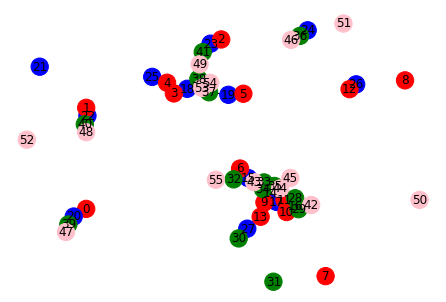

In [44]:
pos = nx.kamada_kawai_layout(G, weight="distance", scale = 10)
nx.draw_spring(G, with_labels=True, node_color=[ g[1]["period"] for g in G.nodes(data=True)])